**Chapter 2: End-to-End Machine Learning Project**

# Get the Data

## Download the Data

In [1]:
import os
import tarfile
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data (housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    
    os.makedirs(housing_path, exist_ok = True)
    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [3]:
def load_housing_data (housing_path = HOUSING_PATH):
    
    csv_path = os.path.join(housing_path, "housing.csv")
    
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()

## Taking a Quick Look at the Data Structure

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


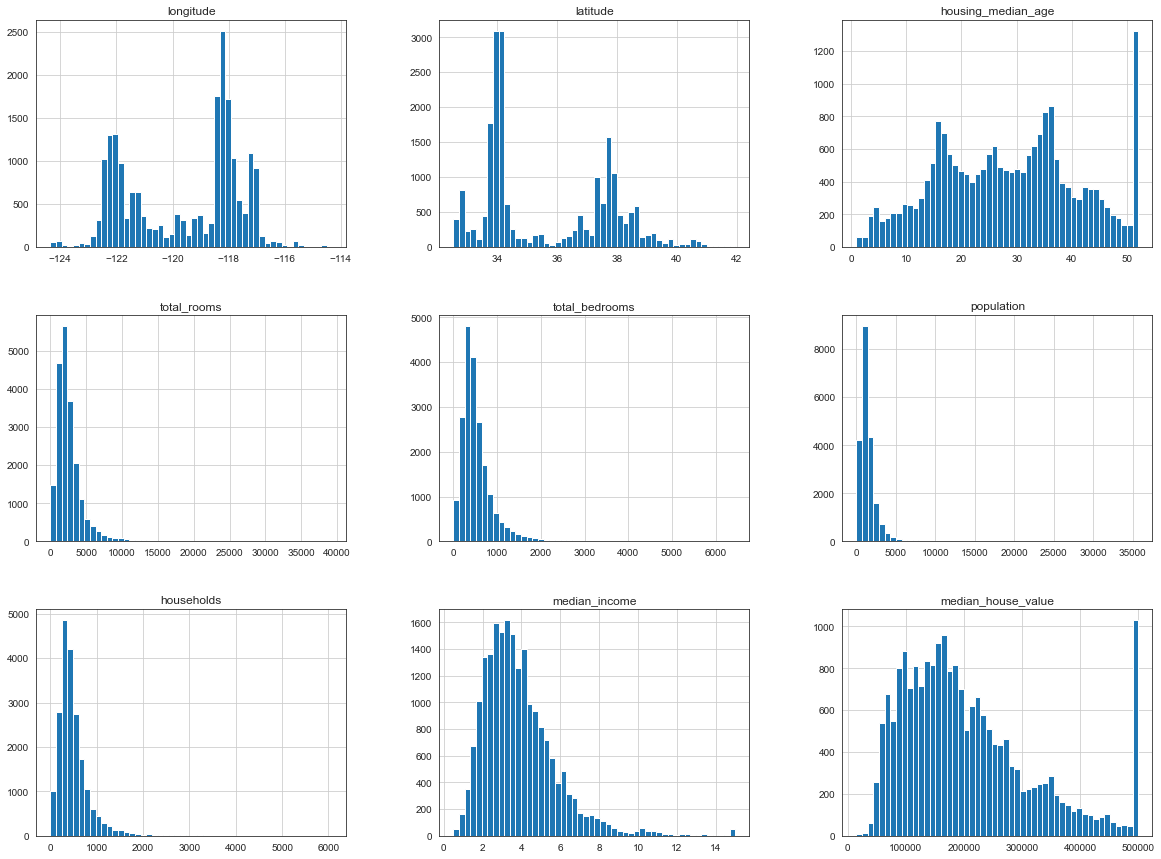

In [8]:
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

We don't want to look too closely at the data, because doing so can cause to see patterns and thus bias the models/algorithms we use and the approaches we take.

A quick look at the data structure and histograms are sufficient to tell us how the data is structured, and potential cleaning/wrangling we will need to undertake.

## Creating a test set

In [9]:
def split_train_test (data, test_ratio):
    
    shuffled_indices = np.random.permutation(len(data))
    
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

To have a stable train/test split. we compute a hash of each instance's unique identifier, and add the instance to the test set if the resulting hash is less than `test_ratio` times the max hash value.

The `housing` dataframe doesn't have a unnique ID, so we add an `index` column and use that instead.

In [10]:
from zlib import crc32

The `zlib` library provides a Python interface to C's `zlib` library, which is an implemntation of the lossless DEFLATE compression algortihm.

The primary purpose of `zlib` is compression and decompression of abitrary data.

The `crc32` function provides a 32-bit hash of the data provided as an argument. CRC-32 itself is an algorithm that performs a 32-bit _Cyclic Redundancy Check_; that is, it attachs a _check value_ to data without modifying it before it is sent somewhere. If the data comes back and the hash of the returned data doesn't match the previously calculated check value, then we know the data was changed somehow, e.g. through corruption.

In [11]:
def test_set_check (identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

Note that the ampersand in `np.int64(identifier)) & 0xffffffff` is not boolean AND, it's bitwise AND, or _conjunction_.

In [12]:
def split_train_test_by_id (data, test_ratio, id_column):
    
    ids = data[id_column]
    
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

Here, the tilde in `data.loc[~in_test_set]` is bitwise NOT, which works because `in_test_set` is an array of boolean values.

Since the housing dataset doesn't actually have an identifier column, we create one:

In [13]:
housing_with_id = housing.reset_index()  # Adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Of course, existing features can also be used as identifiers, like latitude and logitude, which are guaranteed to be stable for a few million years. However, latitude and longitude are coarse, so multiple districts may be represented by the same latitude-longitude pair.

Skikit-Learn provides functions that split datasets into train and test data, the simplest of which is `train_test_split`, which does essentially the same thing as the `split_train_test` function, but with some more features:

1. One can set the random generator seed using the `random_state` parametre.
2. One can pass multiple datasets with an identical number of rows, and it splits them on the same indices (useful if the data and labels are in different data sets).

Usage:
```python
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
```

When selecting samples, it is important to ensure that the sample is representative of the actual population. For instance, one might ensure that thte ratio of men to women selected for a study is as close as possible to the ratio of men to women in the actul population.

This is called _stratified sampling_, since the population is divided into homogenous _strata_ and the right number of instances are sampled from each stratum to get a representative sample.

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0., 1.5, 3., 4.5, 6., np.inf],
                              labels = [1, 2, 3, 4, 5])

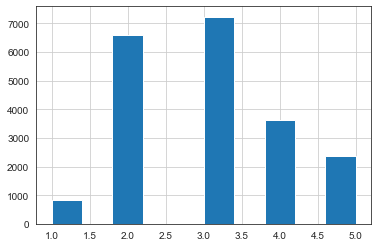

In [15]:
housing["income_cat"].hist()
plt.show()

**NOTE:** Figure out how to fix the spacing on this histogram. TF is that?

Now we can perform stratified sampling based on income category.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

**NOTE:** Might be worth investigating how `StratifiedShuffleSplit` works behind the scenes.

We only needed the `income_cat` attribute to create stratified train- and test sets, se we can drop the column now:

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

# Discover and Visualize the Data to Gain Insights

In [19]:
housing = strat_train_set.copy() # Create a copy to play around with without fear of messing up the original

## Visualizing Geographical Data

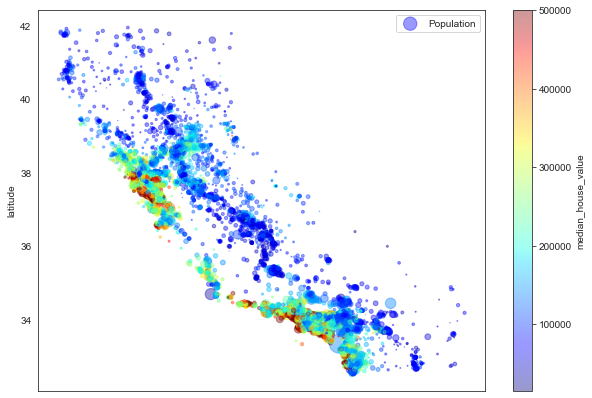

In [20]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"] / 100, label = "Population", figsize = (10, 7),
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True
)
plt.legend()
plt.show()

## Looking for Correlations

Correlation between two attributes can be measured using the _standard correlation coefficient_, also called _Pearson's r_, which can be calculated using
$$
r = \frac{(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}.
$$

As you would expect, this is computationally expensive, so it's more useful for small datasets (like the housing dataset we are using).

Luckily, Pandas comes with the `corr()` method that calculates the standard correlation coefficient matrix for a dataset, so we don't have to type out the whole formula:

In [21]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

It should be noted that the correlation coefficient only measures _linear_ correlation. That is, whether $ y $ _generally_ goes up or down with respect to $ x $.

Another way to check for correlation between attribute pairs is using the Pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute.

In our case, there are 11 numerical attributes, which would result in 121 plots. Seems rather cumbersome. Instead, we can choose to focus on the few that the `corr_matrix` tells us have a strong correlation with `median_house_value`:

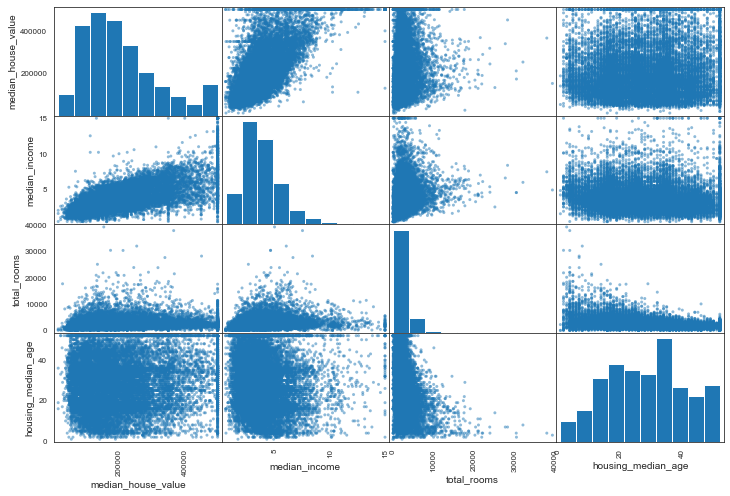

In [22]:
from pandas.plotting import scatter_matrix

attributes = [ "median_house_value", "median_income", "total_rooms", "housing_median_age" ]

scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

Notice that Pandas doesn't plot each attribute against itself, which would just result is a straight, diagonal line, and not be useful. Instead, it provides a histogram of each attribute. Thanks, Pandas!

The median house value seems to be most strongly correlated with median income, so let's focus on that plot:

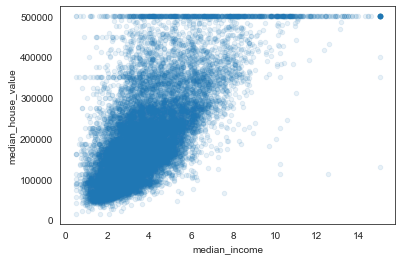

In [23]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)
plt.show()

## Experimenting with Attribute Combinations

In [24]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [25]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

Creating new features was illuminating: now we see that the number of bedrooms per room has a pretty strong correlation with median house value. The correlation coefficient is negative, which makes sense: if there are few rooms (i.e. if the house is smaller) then bedrooms will make up a higher portion of the rooms.

# Prepare the Data for Machine Learning Algorithms

In [26]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

As the output of the `info()` method near the beginning reveals, there are some missing values in the `total_bedrooms` column. There are three strategies to deal with this:

1. Get rid of the corresponding districts. Since the districts with missing values make up such a small portion of the total, this is a viable option.

```python
housing_drop_na_districts = housing.dropna(subset = ["total_bedrooms"])
```

2. Get rid of the whole attribute. The `total_bedrooms` attribute isn't by itself a strong predictor for `median_house_value`, but, as shown, `bedrooms_per_room` is. Thus while this is a potential option, I'm not fond of it.

```python
housing_drop_total_bedrooms = housing.drop("total_bedrooms", axis = 1)
```

3. Replace the missing values with some value, e.g. zero, the mean, the median, etc. I'm not a fan of this at all. One has to compute the median on the training set and save it so it can be used to fill in missing values in the test set and also the missing values it encounters when it goes live.

```python
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace = True)
```

Scikit-Learn provides a handy way of taking care of missing values called `SimpleImputer` (no, that's not a typo, I triple-checked). Its name comes from the word _imputation_, which in finance has the definition
> The assignment of a value to something by inference from the value of the products or processes to which it contributes

according to Google.

In [27]:
from sklearn.impute import SimpleImputer

# Tell the imputer we want to replace missing values of each attribute
# with the median of the known values of the attribute.
imputer = SimpleImputer(strategy = "median")

# We can only computer median of numerical attribues,
# so we get rid of the categorical `ocean_proximity` attribute.
housing_numerical = housing.drop("ocean_proximity", axis = 1)

# Calculate what values to use to fill missing values in each column
imputer.fit(housing_numerical)

# This is where the calculated values are stored
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Comparing these with the medians to make sure everything is good:

In [28]:
housing_numerical.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Cool! Now we can use the imputer to fill in the missing values:

In [29]:
# The `transform` method returns a simple Pandas array...
X = imputer.transform(housing_numerical)
# ...so we turn it back into a dataframe:
housing_transformed = pd.DataFrame(X, columns = housing_numerical.columns, index = housing_numerical.index)

## Handling Text and Categorical Attributes

In [30]:
housing_categorical = housing[["ocean_proximity"]]
housing_categorical.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [31]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

# Equivalent to calling `fit` and then `transform`
housing_categorical_encoded = ordinal_encoder.fit_transform(housing_categorical)
# Again, the `transform` method returned an array, so we transform it to a dataframe
housing_categorical_transformed = pd.DataFrame(
    housing_categorical_encoded,
    columns = housing_categorical.columns,
    index = housing_categorical.index
)

housing_categorical_transformed.head(10)

,ocean_proximity
12655,1.0
15502,4.0
2908,1.0
14053,4.0
20496,0.0
1481,3.0
18125,0.0
5830,0.0
17989,0.0
4861,0.0


The list of categories can be seen via

In [32]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

and the enconding integer of each category is its index.

One issue with this is that machine learning algorithms will assume that categories with close numerical values are more similar. In our case, for instance, it will assume that category `0` (`<1H OCEAN`) is closest to category `1` (`INLAND`), even though `0` is most similar to `4` (`NEAR OCEAN`).

A solution is to use a binary attribute per category, that is `1` when the instance falls into that category and `0` otherwise. This is called _one-hot encoding_, because one value is hot (`1`) while the others are cold (`0`).

In [33]:
from sklearn.preprocessing import OneHotEncoder

categorical_encoder = OneHotEncoder()

# Returns a SciPy sparse matrix, rather than an array, for storage and performance optimization
housing_categorical_1hot = categorical_encoder.fit_transform(housing_categorical)

# But we can see the values by turning it into an array if we wish
housing_categorical_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Now, the algorithm won't think that one category is similar to any other, since each is represented by an array of values, rather than a single number (no, these aren't interpreted as binary numbers either).

**NOTE:** Sparse matrices are matrices comprised of mostly zeroes. Since all zeroes are the same, these matrices can be represented by smaller data structures that are easier to process than "dense" matrices (matrices that are mostly non-zero).

If a categorical attribute has a large number of possible categories, then veen with a sparse matrix one-hot encoding would result in a large number of input features, resulting in peformance degradation. In this case, consider replacing the categorical attribute with one or more useful numerical attributes that are related to the category, e.g. salary instead of profession, gdp and population instead of country code, etc.

## Custom Transformers

To get custom transformers to work seamlessly with Scikit-Learn, one need only create a class and implement the methods `fit()` (returning `self`), `transform()`, and `fit_transform()`. Adding `TransformerMixin` as a base class gives the last one for free. Adding `BaseEstimator` as a base class and avoiding `*args` and `**kargs` in the constructor provides the `get_params()` and `set_params()` methods that are useful for hyperparameter tuning.

For instance, this transformer class adds the combined attributes explored earlier:

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder (BaseEstimator, TransformerMixin):
    
    def __init__ (self, add_bedrooms_per_room = True): # No *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
        
    def fit (self, X, y = None):
        return self # Nothing else to do
    
    
    def transform (self, X, y = None):
        
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attributes = attr_adder.transform(housing.values)

In [35]:
housing_extra_attributes

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

This class has one hyperparameter: `add_bedrooms_per_room`. Adding sensible hyperparameters can be immensely helpful, as they can "gate" a data preparation step you're not totally sure about, and allows you to automatically test them out, which makes it more likely that you will find a good combination.

## Feature Scaling

Machine learning algorithms tend not to perform well when the input numerical values have very different scales. This can be seen in the housing dataset, where the total number of rooms ranges from about 6 to 39, 320, whereas the median income ranges from about 0 to 15.

**NOTE:** Scaling the target values (`median_house_value` in our case) is generally not required.

There are two common ways to perform feature scaling:

1. **Min-max scaling or normalization.** Values are shifted and rescaled so they end up ranging from 0 to 1. This is done by subtracting the minimum value and dividing everything by the range (max - min). Scikit-Learn provides the `MinMaxScaler` transformer to do this, and it has a hyperparameter called `feature_range` in case we don't want the final values to range from 0 to 1.

2. **Standardization.** Standardization subtracts the mean (so the standardized values always have a mean of 0) and then divides by the standard deviation, so that the resulting distribution has unit variance. Scikit-Learn provides the `StandardScaler` transformer for standardization.

While some algorithms require normalized input (like neural nets), standardization is much less affected by outliers. For example, if a median income of 100 ($100, 000) was reported by accident, then normalization would crush all the other values to a range of 0&ndash;0.15.

**NOTE:** As with all transformations, scalers must be fit to training data _only_, not to the full dataset. Only then can can they be used to transform the training set and the test set (and new data).

## Transformation Pipelines

Since there are many data transformations that need to occur in the right order for successful training, Scikit-Learn provides the `Pipeline` class to help such transformation sequences. Here is a pipeline that applies all our transformations to numerical attributes:

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("combined_attributes_adder", CombinedAttributesAdder()),
    ("standard_scaler", StandardScaler())
])

housing_numerical_transformed = numerical_pipeline.fit_transform(housing_numerical)

The `Pipeline`'s `fit()` method calls the `fit_transform()` method on all of them except the last, on which it calles `fit()`.

The `fit_transform()` method calls the `fit_transform()` method on all the estimators.

Thus far the numerical and categorical attributes have been handled separately. For convenience, Scikit-Learn provides the `ColumnTransformer`to apply the specified transformation sequences for each column:

In [37]:
from sklearn.compose import ColumnTransformer

numerical_attributes = list(housing_numerical)
categorical_attributes = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_attributes),
    ("categorical", OneHotEncoder(), categorical_attributes)
])

housing_prepared = full_pipeline.fit_transform(housing)

Note that `OneHotEncoder` returns a sparse matrix, while the `numerical_pipeline` returns a dense matrix. When there is such a mix of matrix densities, the `ColumnTransformer` estimates the density of the final matrix and returns a sprase matrix if the density is lower than a threshold value (by default, `sparse_threshold = 0.3`).

Instead of specifying a transformer, we can specify the string `"drop"` or `"passthrough"` if we want the column to be dropped or left alone, respectively.

By default, unlisted columns are dropped, but we can set the `remainder` hyperparameter to any transformer or to `"passthrough"` to have them handled differently.

# Select and Train a Model

## Training and Evaluating on the Training Set

Training a linear regression model:

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [41]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


It works! We can measure the predictions' RMSE using Scikit-Learn's `mean_squared_error()` function:

In [43]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

68627.87390018745

Hmm. An RMSE of $68, 628 is not at all satisfying. A RMSE this large is a indicative of underfitting, to which there are three solutions:

1. Feed the model better features. We might try the log of the population, for example.
2. Use a better model. Linear Regression is very basic and, well, linear. Non-linear relationships between the median house value and the features we're using won't be well modelled by it.
3. Reduce constraints on the model. This doesn't apply, since our model isn't regularized.

Let's try a different model; in this case, a `DecisionTreeRegressor`:

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

0.0

...we can be fairly certain this is a case of overfitting. But how do we make sure without using the test set? Cross-validation!

## Better Evaluation Using Cross-Validation

One way to evaluate the model would be to split the training set further into a training set and validation set, then train the model on the smaller training set and evaluate it with the validation set.

A good alternative is to use Scikit-Learn's _K-fold cross-validation_ feature. The following code randomly splits the training set into ten subsets, or _folds_, then trains the Decision Tree model ten times, picking a different fold for evaluation every time and training on the other nine folds. The result in an array containing the ten evaluation scores:

In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10)

tree_rmse_scores = np.sqrt(-scores)

**NOTE:** Scikit-Learn's cross-validation features require a utility function (where higher is better) rather than a cost function (where lower is better), so the scoring function is the opposite of MSE (i.e. a negative value). This is why we compute `-scores` before calculating the square root.

Let's see the results:

In [49]:
def display_scores (scores):
    
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())
    

display_scores(tree_rmse_scores)

Scores:  [71426.34090774 69690.20698892 68884.16150174 70456.75091438
 70224.77146183 78233.47795373 71677.46283727 72720.4429373
 69290.47972863 70229.22555736]
Mean:  71283.33207888897
Standard deviation:  2563.7094402752573


Let's compare that to the linear regression scores:

In [54]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring = "neg_mean_squared_error", cv = 10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean:  69104.07998247063
Standard deviation:  2880.328209818064


...yep. The Decision Tree model overfit so badly, it actually performs worse than the linear regression model.

Let's now try the `RandomForestRegressor`:

In [55]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_rmse

18865.25409917056

In [56]:
lin_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10)

forest_rmse_scores = np.sqrt(-lin_scores)

display_scores(forest_rmse_scores)

Scores:  [51263.45187295 48877.27839794 46772.26211854 51838.28948588
 47443.37066172 51906.65501252 51917.46220121 49974.46756306
 48445.43278911 53833.71952433]
Mean:  50227.23896272521
Standard deviation:  2170.2793310412353


Much better! Random forest takes a heck of a long time, though. Might have to look into optimizing it. Still worth noting though that the score on the training set is significantly lower than on the validation sets, implying that the model is still overfitting.

Possible solutions to overfitting are

1. Simplify the model.
2. Regularize the model (i.e. add constraints).
3. Get a lot more training data.

**TIP:** Save every model you experiment with so that you can come back easily to any of those models later. Save hyperparameters and trained parameters, as well as cross-validation test and perhaps the actual predictions too. This allows you to compute scores across model types, and compare the errors they make.

Scikit-Learn models can be saved using Python's `pickle` module, or by using the `joblib` library which is more efficient at serializing large NumPy arrays. Install `joblib` using pip, and then
```python
import joblib

joblib.dump(my_model, "my_model.pkl")

# And later...

my_model_loaded = joblib.load("my_model.pkl")
```

# Fine-Tune Your Model

## Grid Search

Scikit-Learn's `GridSearchCV` estimator experiments with various hyperparameter value combinations to find optimal values, so we don't have to do so manually, which would be tedious.

Let's apply it to the hyperparameter values of the `RandomForestRegressor`:

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    { "n_estimators" : [ 100, 150, 200, 250, 300 ], "max_features" : [ 4, 6, 8, 10 ] },
    { "bootstrap" : [ False ], "n_estimators" : [ 3, 10 ], "max_features" : [ 2, 3, 4 ] }
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV( forest_reg, param_grid, cv = 5,
                          scoring = "neg_mean_squared_error",
                          return_train_score = True )

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [4, 6, 8, 10],
                          'n_estimators': [100, 150, 200, 250, 300]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [63]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 300}

In [65]:
grid_search.best_estimator_ # Get the best estimator directly

RandomForestRegressor(max_features=6, n_estimators=300)

Evaluation scores can be checked like so:

In [67]:
cv_results = grid_search.cv_results_

for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_score), params)

49547.14294661942 {'max_features': 4, 'n_estimators': 100}
49518.98413368799 {'max_features': 4, 'n_estimators': 150}
49362.026565496206 {'max_features': 4, 'n_estimators': 200}
49407.782512791884 {'max_features': 4, 'n_estimators': 250}
49354.89650099891 {'max_features': 4, 'n_estimators': 300}
49408.323851584464 {'max_features': 6, 'n_estimators': 100}
49019.02775801036 {'max_features': 6, 'n_estimators': 150}
49083.01630724494 {'max_features': 6, 'n_estimators': 200}
49184.84242603297 {'max_features': 6, 'n_estimators': 250}
48981.14516173726 {'max_features': 6, 'n_estimators': 300}
49289.62859619854 {'max_features': 8, 'n_estimators': 100}
49221.946122241476 {'max_features': 8, 'n_estimators': 150}
49243.09021389943 {'max_features': 8, 'n_estimators': 200}
49005.44208199986 {'max_features': 8, 'n_estimators': 250}
49117.80433371455 {'max_features': 8, 'n_estimators': 300}
49594.79622566697 {'max_features': 10, 'n_estimators': 100}
49478.06155464069 {'max_features': 10, 'n_estimator

## Randomized Search

Grid search is good when exploring relatively few combinations. When the hyperparameter space is large, randomized search is preferable. Randomized search evaluates a given number of random combinations, by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

1. If we let the randomized search run for $ n $ iterations, it will explore $ n $ different values for each hyperparameter, as opposed to just a few values per hyperparameter with the grid search approach.
2. Just setting the number of iterations gives us more control over the computing budget we wish to allocate to hyperparameter search.

The `RandomizedSearchCV` class is the randomized search equivalent of `GridSearchCV`.

## Ensemble Methods

Another way to fine-tune the system is to combine models that work best, particularly if the models make very different kinds of errors. Explored further in Chapter 7.

## Analyze the Best Models and Their Errors

Inspecting the best models often gives good insights. For instance the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions:

In [70]:
feature_importances = grid_search.best_estimator_.feature_importances_

feature_importances

array([7.62431355e-02, 6.84940941e-02, 4.29578666e-02, 1.79333699e-02,
       1.66048668e-02, 1.75775858e-02, 1.63877524e-02, 3.40120225e-01,
       5.58221951e-02, 1.05936740e-01, 7.32000436e-02, 1.09291227e-02,
       1.49599669e-01, 7.35186457e-05, 3.04659399e-03, 5.07322127e-03])

The importance scores next to their corresponding attribute names:

In [71]:
extra_attributes = [
    "rooms_per_household",
    "population_per_household",
    "bedrooms_per_room"
]

categorical_encoder = full_pipeline.named_transformers_["categorical"]

categorical_one_hot_attributes = list(categorical_encoder.categories_[0])

attributes = numerical_attributes + extra_attributes + categorical_one_hot_attributes

sorted(zip(feature_importances, attributes), reverse = True)

[(0.34012022537918885, 'median_income'),
 (0.1495996686139608, 'INLAND'),
 (0.10593673964304788, 'population_per_household'),
 (0.07624313550926894, 'longitude'),
 (0.07320004359875679, 'bedrooms_per_room'),
 (0.0684940941405409, 'latitude'),
 (0.05582219506266575, 'rooms_per_household'),
 (0.04295786662116346, 'housing_median_age'),
 (0.01793336989811994, 'total_rooms'),
 (0.01757758577555569, 'population'),
 (0.016604866817452702, 'total_bedrooms'),
 (0.016387752382064354, 'households'),
 (0.010929122653887813, '<1H OCEAN'),
 (0.005073221267105455, 'NEAR OCEAN'),
 (0.0030465939914834568, 'NEAR BAY'),
 (7.351864573722137e-05, 'ISLAND')]

This tells us that only the `ISLAND` category of the `near_ocean` attribute has any real impact, so we might drop the other categories and turn it into a boolean (e.g. `is_island`).

## Evaluate Your System on the Test Set

Once we've tweaked the model enough and have a sufficiently well performing system, we can evaluate the model on the test set:

1. Extract the labels and predictors from the test set
2. Run the `full_pipeline` to transform the data by calling `transform()` (_not_ `fit()` or `fit_transform()`; we don't want to fit the model to the test set!)
3. Evaluate the final model

In [73]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

46809.923583859076


We can compute a 95% confidence interval for the generalization error estimate using `scipy.stats.t.interval()` to get a better idea of how precise the estimate is in case, for instance, the fine-tuned model is only 0.1% better than the model currently in production and you're unsure of whether to launch:

In [74]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(
    stats.t.interval(
        confidence,
        len(squared_errors) - 1,
        loc = squared_errors.mean(),
        scale = stats.sem(squared_errors)
    )
)

array([44844.93007234, 48695.68911783])

Jheze that's quite good, compared to the RMSE of 68, 000-ish we had before.

**NOTE:** If a lot of hyperparameter tuning was done, the performance will usually be slightly worse than was measured using cross-validation, since the system will end up being tuned to perfomr well on the validation data, and will likely not perform well on unknown datasets. When this happens, _do not_ tweak the hyperparameters to make the numbers look good on the test set, because, once again, such tuning would not make the model work any better on new data.

After evaluation is complete, it's time for pre-launch:

1. Present your solution, highlighting:
    a. what you learned,
    b. what worked and what did not,
    c. the assumptions that were made, and
    d. the system's limitations
2. Document everything
3. Create a nice presentation with clear visualizations and easy-to-remember statements (e.g. "the median income is the best predictor of housing prices")

In our case, the model did not perform much better than the experts' estimates, but it may still be a good idea to launch it, easpecially if it frees up the experts to work on other stuff.